<a href="https://colab.research.google.com/github/juacardonahe/Curso_NLP/blob/main/1_FundamentosNLP/1.4_FoundationModels/1_4_1_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/juacardonahe/Curso_NLP/refs/heads/main/data/UnFieldB.png" width="40%">

# **Natural Language Procesing (NLP)**
### Departamento de Ingeniería Eléctrica, Electrónica y Computación
#### Universidad Nacional de Colombia - Sede Manizales

#### Created by: Juan José Cardona H.
#### Reviewed by: Diego A. Perez

#**1.4.1 - Recurrent Neural Networks (RNNs)**
A Recurrent Neural Network (RNN) is a type of neural network architecture specifically designed to handle sequential data by maintaining a memory of previous inputs. This is achieved through connections that form loops in the network, allowing information to persist. Unlike traditional feed-forward neural networks, which assume that inputs are independent of each other, RNNs use their internal state (memory) to process sequences of inputs. This makes them especially useful for tasks where the order of inputs matters, such as time-series data, language modeling, or video sequences.

##**What is Sequential Data?**
Sequential data is information that has a specific order and where the order matters. Each piece of data in the sequence is related to the ones before and after it, and this order provides context and meaning to the data as a whole.

**Why is important?**

Imagine a sentence like “The quick brown fox jumps over the lazy dog.” Each word in the sentence is a piece of data. The order of the words is crucial because it determines the meaning of the sentence. “Fox brown quick the jumps over lazy dog” wouldn’t make much sense, right?

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## **Loading and visualizing the data**

We load the dataset from a GitHub URL and visualize the time series to understand its trends and seasonality.

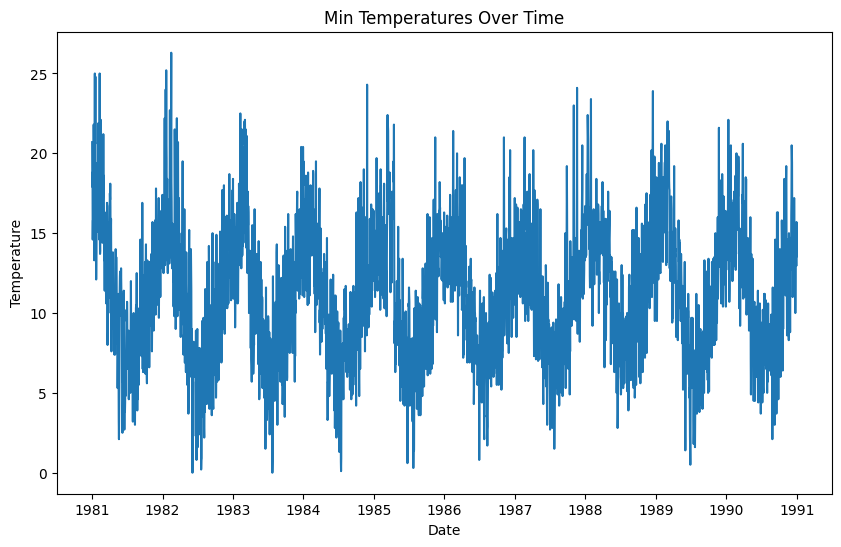

In [ ]:
# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
data = pd.read_csv(url, parse_dates=['Date'], index_col='Date')

# Plot the data
plt.figure(figsize=(10,6))
plt.plot(data)
plt.title('Min Temperatures Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

## **Data Preprocessing**

We preprocess the data by:

1. **Normalizing**: Scaling temperature numbers to [0, 1] using MinMaxScaler.
2. **Creating Sequences**: Transforming the time series into sequences of 12 months to predict the next month.
3. **Splitting**: Dividing into 80% training and 20% testing sets, preserving temporal order.

In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.values)

# Function to create sequences
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

# Set sequence length (e.g., 12 months)
seq_length = 12
x, y = create_sequences(data_scaled, seq_length)

# Split into train and test
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training samples: {x_train.shape[0]}, Testing samples: {x_test.shape[0]}")

Training samples: 2910, Testing samples: 728


## **Implementing the RNN**

The `SimpleRNN` class implements a basic RNN with:

- **Weights**: Input to hidden (W_xh), hidden to hidden (W_hh), hidden to output (W_hy).
- **Forward Pass**: Processes sequences to compute hidden states and predictions.
- **Backward Pass**: Uses backpropagation through time (BPTT) to compute gradients.

The RNN uses tanh activation for hidden states and mean squared error for loss.

In [ ]:
class SimpleRNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights
        self.W_xh = np.random.randn(input_size, hidden_size) * 0.01  # Input to hidden
        self.W_hh = np.random.randn(hidden_size, hidden_size) * 0.01  # Hidden to hidden
        self.W_hy = np.random.randn(hidden_size, output_size) * 0.01  # Hidden to output
        self.b_h = np.zeros((1, hidden_size))  # Bias for hidden layer
        self.b_y = np.zeros((1, output_size))  # Bias for output layer

    def forward(self, x):
        # Initialize hidden state
        batch_size = x.shape[0]
        seq_length = x.shape[1]
        h = np.zeros((batch_size, self.hidden_size))
        self.hs = {}

        # Process each time step
        for t in range(seq_length):
            a = np.dot(x[:, t, :], self.W_xh) + np.dot(h, self.W_hh) + self.b_h
            h = np.tanh(a)
            self.hs[t] = h

        # Compute output
        y_pred = np.dot(h, self.W_hy) + self.b_y
        return y_pred

    def compute_loss_and_grads(self, x, y):
        # Forward pass
        y_pred = self.forward(x)
        # Compute loss (mean squared error)
        loss = np.mean((y_pred - y)**2)

        # Backward pass
        dy = (2 / x.shape[0]) * (y_pred - y)  # Gradient of loss w.r.t. y_pred
        dW_hy = np.dot(self.hs[x.shape[1]-1].T, dy)  # Gradients for output layer
        db_y = np.sum(dy, axis=0, keepdims=True)
        dh = np.dot(dy, self.W_hy.T)  # Gradient to final hidden state

        # Initialize gradients for RNN parameters
        dW_xh = np.zeros_like(self.W_xh)
        dW_hh = np.zeros_like(self.W_hh)
        db_h = np.zeros_like(self.b_h)

        # Backprop through time
        for t in reversed(range(x.shape[1])):
            da = dh * (1 - self.hs[t]**2)  # Gradient through tanh
            dW_xh += np.dot(x[:, t, :].T, da)
            if t > 0:
                dW_hh += np.dot(self.hs[t-1].T, da)
            else:
                dW_hh += np.dot(np.zeros_like(self.hs[0]).T, da)
            db_h += np.sum(da, axis=0, keepdims=True)
            if t > 0:
                dh = np.dot(da, self.W_hh.T)

        grads = {'W_xh': dW_xh, 'W_hh': dW_hh, 'W_hy': dW_hy, 'b_h': db_h, 'b_y': db_y}
        return loss, grads

## **Training the RNN**

We train the RNN using gradient descent with:

- **Hidden size**: 50 units
- **Learning rate**: 0.01
- **Epochs**: 100
- **Batch size**: 10

The training loop processes batches, computes loss and gradients, and updates weights.

Epoch 0, Loss: 0.03985077133099534
Epoch 10, Loss: 0.02227624585465535
Epoch 20, Loss: 0.01612342883201778
Epoch 30, Loss: 0.0100976344428697
Epoch 40, Loss: 0.00978486849578216
Epoch 50, Loss: 0.009777360885474432
Epoch 60, Loss: 0.009773606790740496
Epoch 70, Loss: 0.00976978257191659
Epoch 80, Loss: 0.009765631068635403
Epoch 90, Loss: 0.009761020448079468


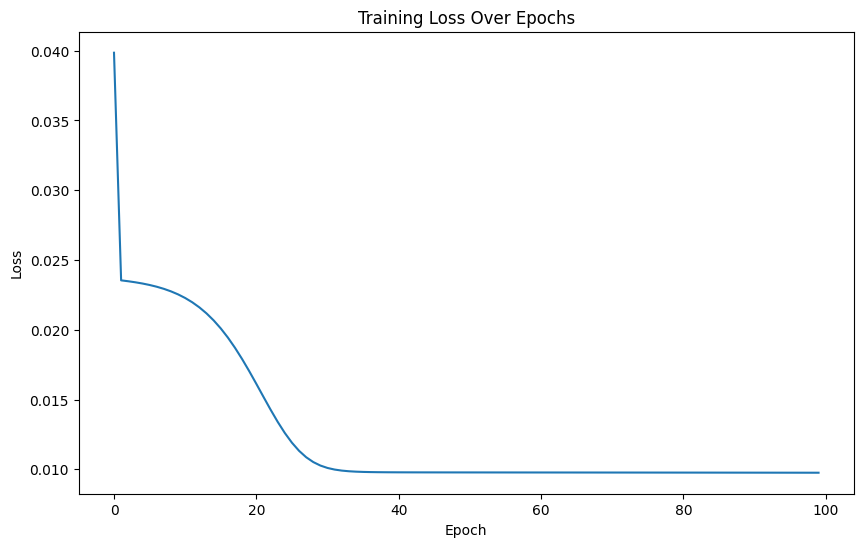

In [ ]:
# Hyperparameters
input_size = 1
hidden_size = 50
output_size = 1
learning_rate = 0.01
epochs = 100
batch_size = 10

# Initialize RNN
rnn = SimpleRNN(input_size, hidden_size, output_size)

# Training loop
losses = []
for epoch in range(epochs):
    total_loss = 0
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        if x_batch.shape[0] == 0:
            continue
        loss, grads = rnn.compute_loss_and_grads(x_batch, y_batch)
        total_loss += loss * x_batch.shape[0]
        # Update parameters
        rnn.W_xh -= learning_rate * grads['W_xh']
        rnn.W_hh -= learning_rate * grads['W_hh']
        rnn.W_hy -= learning_rate * grads['W_hy']
        rnn.b_h -= learning_rate * grads['b_h']
        rnn.b_y -= learning_rate * grads['b_y']
    average_loss = total_loss / len(x_train)
    losses.append(average_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {average_loss}")

# Plot training loss
plt.figure(figsize=(10,6))
plt.plot(losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## **Evaluating the Model**

We evaluate the model on the test set, inverse transform predictions to the original scale, and plot actual vs. predicted values to assess performance.

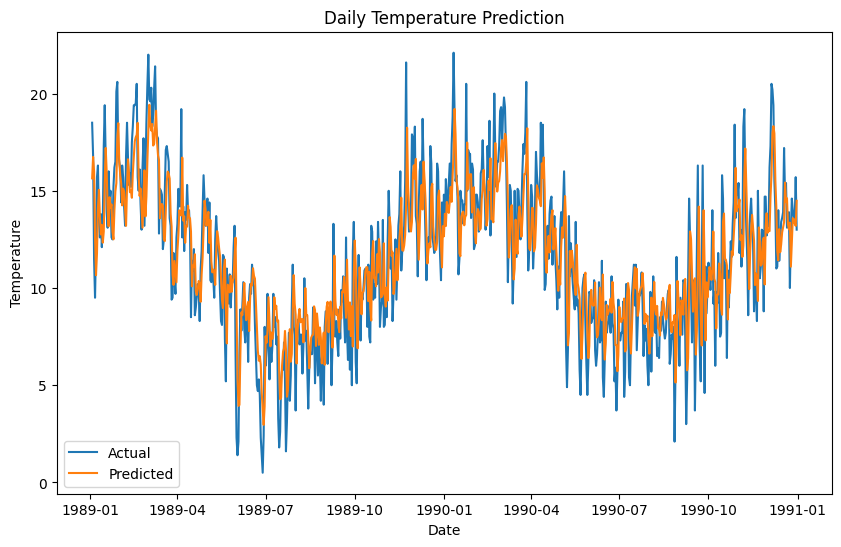

In [ ]:
# Predict on test set
y_pred_scaled = []
for i in range(len(x_test)):
    pred = rnn.forward(x_test[i:i+1])
    y_pred_scaled.append(pred[0])
y_pred_scaled = np.array(y_pred_scaled)

# Inverse transform
y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred_scaled)

# Plot
plt.figure(figsize=(10,6))
plt.plot(data.index[-len(y_test):], y_test_original, label='Actual')
plt.plot(data.index[-len(y_test):], y_pred_original, label='Predicted')
plt.title('Daily Temperature Prediction')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()